In [1]:
#csv desde drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq as hq
from keras import backend as K

from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, GRU, Dropout, RepeatVector
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [0]:
more_days = [1, 3, 5, 6, 7, 9, 12]

def sum_day(day, month, year):
    day = day + 1
    if day == 29:
        if month == 2:
            day = 1
            month += 1
    elif day == 31:
        if month not in more_days:
            day = 1
            month += 1
    elif day == 32:
        if month == 12:
            day = 1
            month = 1
            year += 1
        else:
            day = 1
            month += 1
    
    return [day, month, year]
  
def in_sale(day, month, year):
    if year == 2017:
        if month == 5:
            if day in [29, 30, 31]:
                return 1
        if month == 11:
            if day in [6, 7, 8]:
                return 1
    if year == 2018:
        if month == 5:
            if day in [28, 29, 30]:
                return 1
        if month == 10:
            if day in [8, 9, 10]:
                return 1
    return 0

In [4]:
values = list()
day_counter = 0

items = {4385959, 168757, 2678016, 4695904}
items_data = {item: [0, 0] for item in items}

day_number, month, year = 1, 1, 2017
#Most selled items ids 4385959, 168757, 2678016, 4695904
#We create our dataset by saving 2 values, times bought in the day and how much did we earn from it
with open('drive/My Drive/Colab Notebooks/costanera2.csv', 'r') as istream:
    for line in istream:
        if line == '\n': continue
        day = list()
        for tup in line.split(';'):
            id_prod, y, z = tuple(map(int, tup.split(',')))
            #Instead of just looking for 1 item, we need to do it for 4
            if id_prod in items:
                items_data[id_prod][0] += y
                items_data[id_prod][1] += z*y
        day.append(in_sale(day_number, month, year))
        for item in items:
            day.append(items_data[item][0])
            day.append(items_data[item][1])
        values.append(day)
        items_data = {item: [0, 0] for item in items}
        date = sum_day(day_number, month, year)
        day_number = date[0]
        month = date[1]
        year = date[2]

#We save our data into a dataframe to easily manage it                
df = pd.DataFrame(data=np.asarray(values), columns=['sale', 'count0', 'money0', 'count1', 'money1', 'count2', 'money2', 'count3', 'money3'], dtype='float32')
df.head()

,sale,count0,money0,count1,money1,count2,money2,count3,money3
0,0.0,9.0,1165995.0,13.0,38714.0,264.0,48048.0,45.0,598140.0
1,0.0,3.0,189000.0,5.0,14950.0,264.0,29304.0,43.0,519010.0
2,0.0,6.0,552996.0,6.0,17940.0,273.0,45045.0,72.0,974376.0
3,0.0,5.0,269000.0,3.0,8970.0,273.0,56784.0,60.0,780600.0
4,0.0,0.0,0.0,5.0,14950.0,293.0,143863.0,83.0,1024303.0


In [5]:
#We separate our data into train and test data
#500 days will be for training and 215 for testing
trainData = df[:600]
testData = df[600:]

print(len(trainData), len(testData))

600 115


In [0]:
#Dropping money cause we wont use it in this example (but it could be used)
trainData = trainData.drop(['money0', 'money1', 'money2', 'money3'], axis=1)
testData = testData.drop(['money0', 'money1', 'money2', 'money3'], axis=1)

forPreds = trainData.copy()
forPreds = forPreds.drop('sale', axis=1)

In [0]:
from sklearn.preprocessing import StandardScaler, RobustScaler

#Scaling our values (including this must includes the values that will be in the 'y' dataset)
scaler = StandardScaler()
scaler.fit(trainData)

scaler2 = StandardScaler()
scaler2.fit(forPreds)

train_data_scaled = scaler.transform(trainData)
test_data_scaled = scaler.transform(testData)

In [0]:
#Here is were we create our dataset
#X will have a lag of 20 days, meaning that it will contain (in separate features) how many items of product 0 were sold in the day
#Y will have just 1 value (1 per item) where it will contain how many items of product were sold in 30 days after the final day of X

#This should look like this with a lag of 3
# [x            | y ]
# [13   30    12| 20]
# [30   12    11| 23]

#Notice that after 30 days have passed the first value of X will be y[0] = 20
def create_dataset(dataset, lag=10):
    #This is to know which entry will be the last one able to be saved
    max_y = len(dataset) - 30
    counter = 1
    y_list, x_list = list(), list()
    temp = list()
    
    for row in range(max_y):
        #Once this condition is accepted then we will start adding our data to the dataset
        if counter > lag:
            y_list.append(dataset[row + 30][1:]) #append the quantity of items sold after 30 days
            x_list.append(np.array(temp))
            temp.pop(0)
        #We create a temp list that will contain the values of X
        temp.append(dataset[row])
        counter += 1
  
    return np.array(x_list), np.array(y_list) #Return Xdata and Ydata

In [0]:
laag = 15
X_train, y_train = create_dataset(train_data_scaled, laag)
X_test, y_test = create_dataset(test_data_scaled, laag)

In [11]:
X_test.shape

(70, 15, 5)

In [0]:
#We need to reshape our data so the network can work with timestamps
#the new format will be (quantity of examples, timestamp, features per day) The last value can have multiple features
#X_train =  np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
#X_test =  np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [13]:
X_train.shape, y_train.shape

((555, 15, 5), (555, 4))

In [0]:
def pinball_loss(tau = 0.5):
  def loss(y_true, y_pred):
    err = y_true - y_pred
    return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
  return loss

pinball = pinball_loss(tau = 0.5)

In [0]:
def plot_losses(hist): 
  plt.figure(figsize=(15, 7))
  
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  
  plt.legend(["Train Loss", "Val Loss"], loc="upper right")
  
  plt.title("Traning & Test Losses")
  
  plt.show()
  
  print("Final Train Loss:",hist.history['loss'][-1])
  print("Min Test Loss:",min(hist.history['val_loss']))

In [16]:
#Our model, it needs to be improved
#Input shape -> Timestamps, features
model1 = Sequential()
model1.add(GRU(units=100, input_shape=(laag, X_train.shape[2]), activation='tanh', return_sequences=True))
model1.add(GRU(units=50, activation='tanh', return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(units=4, activation='linear'))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.summary()

W0801 22:42:41.851371 140455745533824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 22:42:41.872922 140455745533824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 22:42:41.876079 140455745533824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 22:42:42.244485 140455745533824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0801 22:42:42.255161 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 15, 100)           31800     
_________________________________________________________________
gru_2 (GRU)                  (None, 50)                22650     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 54,654
Trainable params: 54,654
Non-trainable params: 0
_________________________________________________________________


In [17]:
history1 = model1.fit(X_train, y_train, epochs=15, batch_size=1, validation_data=(X_test, y_test), verbose=0)

W0801 22:42:42.636844 140455745533824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0801 22:42:43.536108 140455745533824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



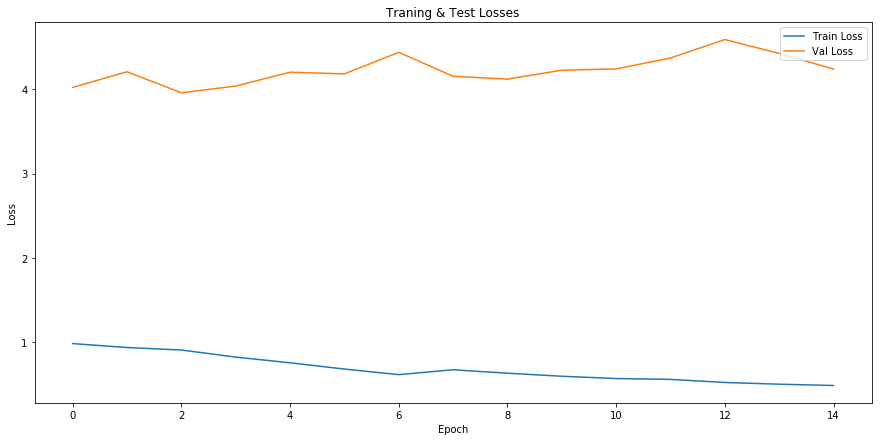

Final Train Loss: 0.4841101273206306
Min Test Loss: 3.9590194835726704


In [18]:
plot_losses(history1)

In [19]:
model2 = Sequential()
model2.add(GRU(units=50, input_shape=(laag, X_train.shape[2]), activation='tanh', return_sequences=True))
model2.add(GRU(units=100, activation='tanh', return_sequences=False))
model2.add(RepeatVector(9))
model2.add(GRU(units=50, activation='tanh', return_sequences=False))
model2.add(Dense(units=100, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(units=4, activation='linear'))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 15, 50)            8400      
_________________________________________________________________
gru_4 (GRU)                  (None, 100)               45300     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 9, 100)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 50)                22650     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 404       
Total para

In [0]:
history2 = model2.fit(X_train, y_train, epochs=15, batch_size=1, validation_data=(X_test, y_test), verbose=0)

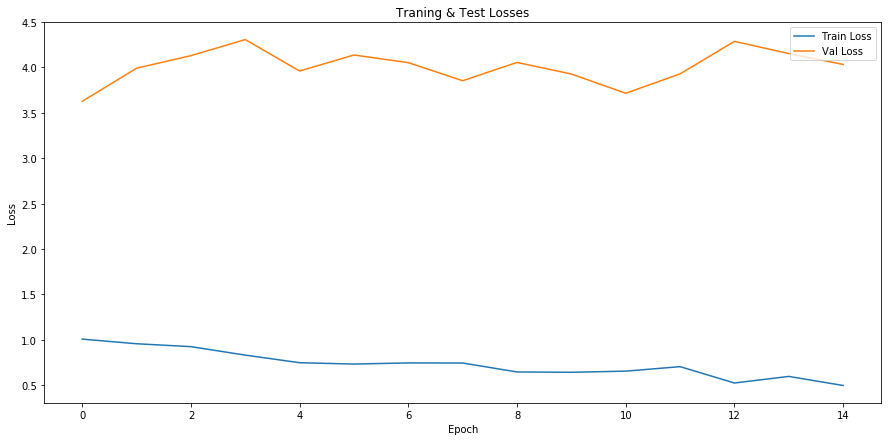

Final Train Loss: 0.49636848371408815
Min Test Loss: 3.626393517692174


In [21]:
plot_losses(history2)

In [22]:
model3 = Sequential()
model3.add(GRU(units=100, input_shape=(laag, X_train.shape[2]), activation='tanh'))
model3.add(Dense(units=4, activation='linear'))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 100)               31800     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 404       
Total params: 32,204
Trainable params: 32,204
Non-trainable params: 0
_________________________________________________________________


In [0]:
#training
history3 = model3.fit(X_train, y_train, epochs=15, batch_size=1, validation_data=(X_test, y_test), verbose=0)

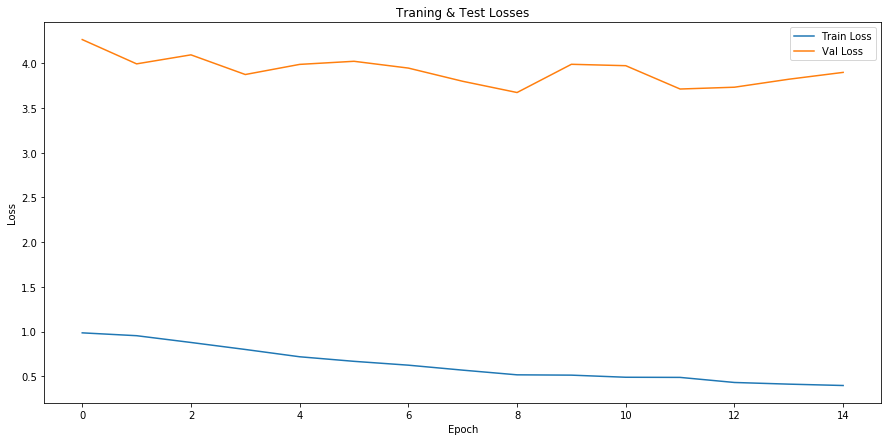

Final Train Loss: 0.39607074585667734
Min Test Loss: 3.6737288176481213


In [24]:
plot_losses(history3)

In [0]:
#And we plot our values
def plot_predictions(model, X_test, y_test):
    #We predict and after that descale our data (remember it was scaled before)
    y_pred = model.predict(X_test)
    y_true = y_test

    y_pred = scaler2.inverse_transform(y_pred)
    y_true = scaler2.inverse_transform(y_true)
    
    prod0_true = [x[0] for x in y_true]
    prod1_true = [x[1] for x in y_true]
    prod2_true = [x[2] for x in y_true]
    prod3_true = [x[3] for x in y_true]

    prod0_pred = [x[0] for x in y_pred]
    prod1_pred = [x[1] for x in y_pred]
    prod2_pred = [x[2] for x in y_pred]
    prod3_pred = [x[3] for x in y_pred]

    plt.figure(figsize=(18,10))

    plt.subplot(221)

    plt.title("Ventas producto 0")

    plt.plot(prod0_pred, '-o')
    plt.plot(prod0_true, '-o')

    plt.legend(['Predicted', 'True'])

    plt.subplot(222)

    plt.title("Ventas producto 1")

    plt.plot(prod1_pred, '-o')
    plt.plot(prod1_true, '-o')

    plt.legend(['Predicted', 'True'])

    plt.subplot(223)

    plt.title("Ventas producto 2")

    plt.plot(prod2_pred, '-o')
    plt.plot(prod2_true, '-o')

    plt.legend(['Predicted', 'True'])

    plt.subplot(224)

    plt.title("Ventas producto 3")

    plt.plot(prod3_pred, '-o')
    plt.plot(prod3_true, '-o')

    plt.legend(['Predicted', 'True'])

    plt.show()

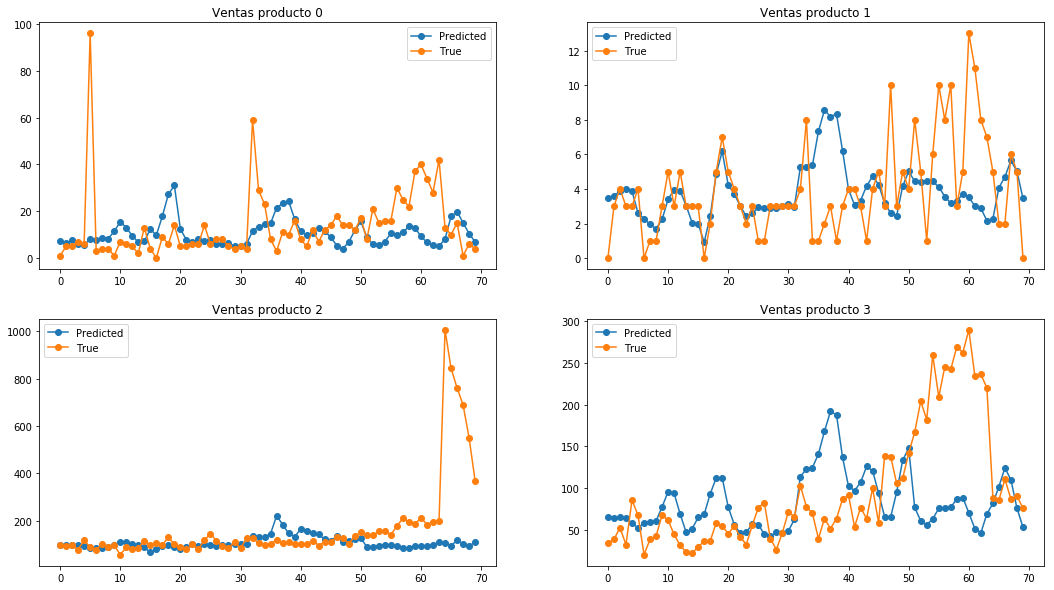

In [26]:
plot_predictions(model1, X_test, y_test)

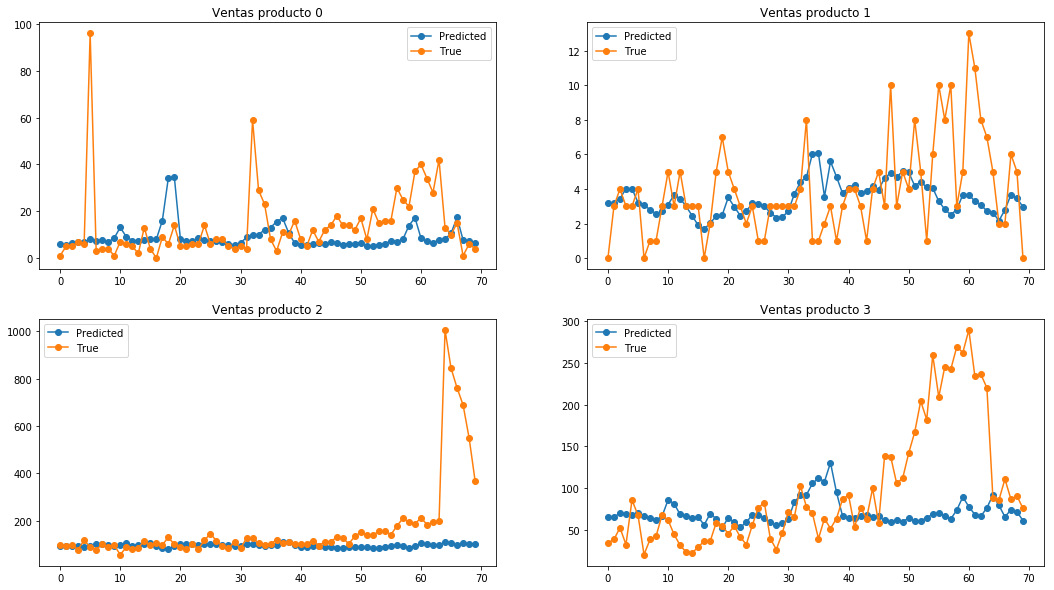

In [27]:
plot_predictions(model2, X_test, y_test)

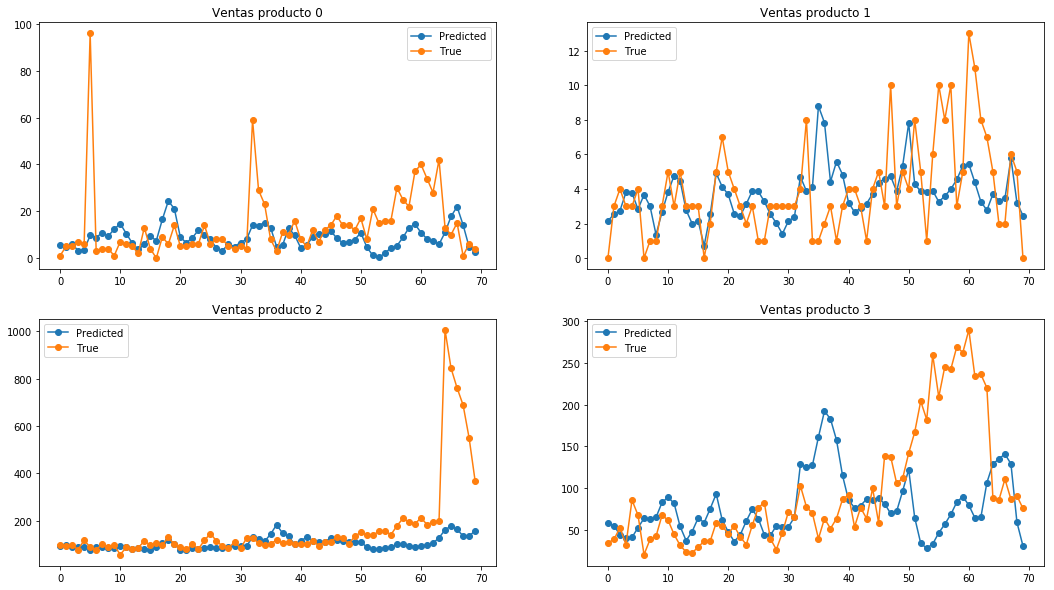

In [28]:
plot_predictions(model3, X_test, y_test)

In [0]:
#Notice that there's a peak at the end, that could mean that during that time there was a special offer like a cyberday
#It could be a good idea to create a feature that determines if we are on a sale day or not (1 or 0)